<a href="https://colab.research.google.com/github/PritamKhan/Data_Analytics/blob/master/Cryptocurrency_Volatility_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [3]:
# Load multi-crypto dataset
df = pd.read_csv("dataset.csv")

In [4]:
# Drop unnecessary index column
df.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

In [6]:
# Sort by crypto and date
df = df.sort_values(by=['crypto_name', 'date'])

In [7]:
# Feature Engineering
# Daily return
df['daily_return'] = df.groupby('crypto_name')['close'].pct_change()

In [8]:
# Rolling volatility (7-day std of return)
df['rolling_volatility_7d'] = df.groupby('crypto_name')['daily_return'].rolling(window=7).std().reset_index(0, drop=True)

In [9]:
# Moving Averages
df['ma_7'] = df.groupby('crypto_name')['close'].transform(lambda x: x.rolling(window=7).mean())
df['ma_14'] = df.groupby('crypto_name')['close'].transform(lambda x: x.rolling(window=14).mean())

In [10]:
# Liquidity ratio
df['liquidity_ratio'] = df['volume'] / df['marketCap']

In [11]:
# Drop rows with NaNs from rolling calculations
df = df.dropna()

In [12]:
# Preview processed data
df.head()

,open,high,low,close,volume,marketCap,timestamp,crypto_name,date,daily_return,rolling_volatility_7d,ma_7,ma_14,liquidity_ratio
45270,51.387610,52.080685,44.018325,44.019183,5.883146e+06,2.215471e+08,2020-10-15T23:59:59.999Z,Aave,2020-10-15,-0.142202,0.071584,49.187271,45.008805,0.026555
45325,42.890607,43.906730,39.142957,39.495844,5.285520e+07,3.650715e+08,2020-10-16T23:59:59.999Z,Aave,2020-10-16,-0.102758,0.074470,48.141285,47.793039,0.144780
45398,39.486192,43.077373,38.633613,41.366993,4.333969e+07,3.823670e+08,2020-10-17T23:59:59.999Z,Aave,2020-10-17,0.047376,0.074141,47.031753,46.951289,0.113346
45457,41.389598,41.749488,39.531586,40.746972,4.044116e+07,3.766360e+08,2020-10-18T23:59:59.999Z,Aave,2020-10-18,-0.014988,0.072888,45.758360,46.099285,0.107375
45502,40.836757,40.995184,35.951364,36.012317,4.928990e+07,3.328722e+08,2020-10-19T23:59:59.999Z,Aave,2020-10-19,-0.116196,0.070810,43.440306,44.870219,0.148075


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and preprocess
df = pd.read_csv("dataset.csv")
df.drop(columns=['Unnamed: 0'], errors='ignore', inplace=True)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['crypto_name', 'date'])

In [14]:
# Feature engineering
df['daily_return'] = df.groupby('crypto_name')['close'].pct_change()
df['rolling_volatility_7d'] = df.groupby('crypto_name')['daily_return'].rolling(window=7).std().reset_index(0, drop=True)
df['ma_7'] = df.groupby('crypto_name')['close'].transform(lambda x: x.rolling(window=7).mean())
df['ma_14'] = df.groupby('crypto_name')['close'].transform(lambda x: x.rolling(window=14).mean())
df['liquidity_ratio'] = df['volume'] / df['marketCap']
df.dropna(inplace=True)

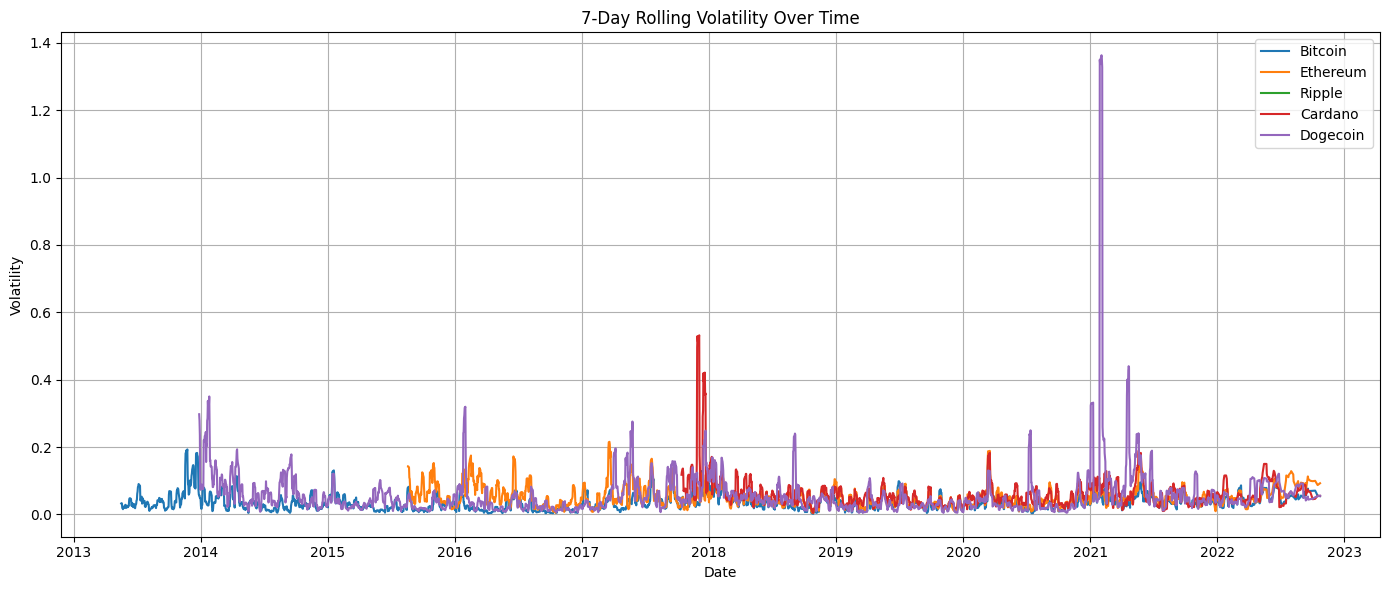

In [15]:
# EDA: Plot rolling volatility for top cryptos
top_cryptos = ['Bitcoin', 'Ethereum', 'Ripple', 'Cardano', 'Dogecoin']
eda_df = df[df['crypto_name'].isin(top_cryptos)]

plt.figure(figsize=(14, 6))
for name in top_cryptos:
    subset = eda_df[eda_df['crypto_name'] == name]
    plt.plot(subset['date'], subset['rolling_volatility_7d'], label=name)
plt.title("7-Day Rolling Volatility Over Time")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
df['target_volatility'] = df.groupby('crypto_name')['rolling_volatility_7d'].shift(-1)

In [17]:
features = [
    'open', 'high', 'low', 'close', 'volume', 'marketCap',
    'daily_return', 'ma_7', 'ma_14', 'liquidity_ratio'
]

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Shift volatility to predict next day
df['target_volatility'] = df.groupby('crypto_name')['rolling_volatility_7d'].shift(-1)

In [19]:
# Drop NaNs after shifting
df_model = df.dropna(subset=['target_volatility'])

In [20]:
# Feature set
features = [
    'open', 'high', 'low', 'close', 'volume', 'marketCap',
    'daily_return', 'ma_7', 'ma_14', 'liquidity_ratio'
]
X = df_model[features]
y = df_model['target_volatility']

In [26]:
# Ensure X is a safe copy
X_clean = X.copy()

# Replace infinite values with NaN
X_clean.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN
X_clean.dropna(inplace=True)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# Also update y to match the cleaned X index
y_clean = y.loc[X_clean.index]

In [27]:
# Chronological split
split_index = int(0.8 * len(X))
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [28]:
# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [29]:
# Predictions
y_pred = model.predict(X_test)

In [30]:
# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [31]:
print("📊 Model Evaluation Metrics:")
print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R² Score: {r2:.4f}")

📊 Model Evaluation Metrics:
MAE: 0.024992
RMSE: 0.038248
R² Score: 0.3201


In [58]:
!pip install xgboost

In [33]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

In [34]:
# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error',
                           verbose=1, n_jobs=-1)

In [35]:
# Fit to training data
grid_search.fit(X_train, y_train)

# Best model
best_xgb = grid_search.best_estimator_

# Predict
y_pred_xgb = best_xgb.predict(X_test)

# Evaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [36]:
print("🔧 Best XGBoost Hyperparameters:")
print(grid_search.best_params_)
print("\n📊 XGBoost Evaluation Metrics:")
print(f"MAE: {mae_xgb:.6f}")
print(f"RMSE: {rmse_xgb:.6f}")
print(f"R² Score: {r2_xgb:.4f}")

🔧 Best XGBoost Hyperparameters:
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

📊 XGBoost Evaluation Metrics:
MAE: 0.024723
RMSE: 0.036295
R² Score: 0.3877


In [54]:
import joblib

# Load the saved model and scaler
model = joblib.load("volatility_model.pkl")
scaler = joblib.load("scaler.pkl")


In [55]:
import pandas as pd

# Load dataset
df = pd.read_csv("dataset.csv")
df['date'] = pd.to_datetime(df['date'])

# Preprocess and feature engineer
df = df.sort_values(by=['crypto_name', 'date'])
df['daily_return'] = df.groupby('crypto_name')['close'].pct_change()
df['rolling_volatility_7d'] = df.groupby('crypto_name')['daily_return'].rolling(window=7).std().reset_index(0, drop=True)
df['ma_7'] = df.groupby('crypto_name')['close'].transform(lambda x: x.rolling(window=7).mean())
df['ma_14'] = df.groupby('crypto_name')['close'].transform(lambda x: x.rolling(window=14).mean())
df['liquidity_ratio'] = df['volume'] / df['marketCap']
df.dropna(inplace=True)


In [56]:
# Pick latest data for a specific crypto
crypto = "Bitcoin"
sample = df[df['crypto_name'] == crypto].sort_values(by="date").iloc[-1:]

features = ['open', 'high', 'low', 'close', 'volume', 'marketCap', 'daily_return', 'ma_7', 'ma_14', 'liquidity_ratio']
X_latest = sample[features]

# Scale the input
X_scaled = scaler.transform(X_latest)

# Predict
predicted_vol = model.predict(X_scaled)[0]

# Display
print(f"📈 Predicted Next-Day Volatility for {crypto} on {sample['date'].values[0]}: {predicted_vol:.6f}")


📈 Predicted Next-Day Volatility for Bitcoin on 2022-10-23T00:00:00.000000000: 0.038736


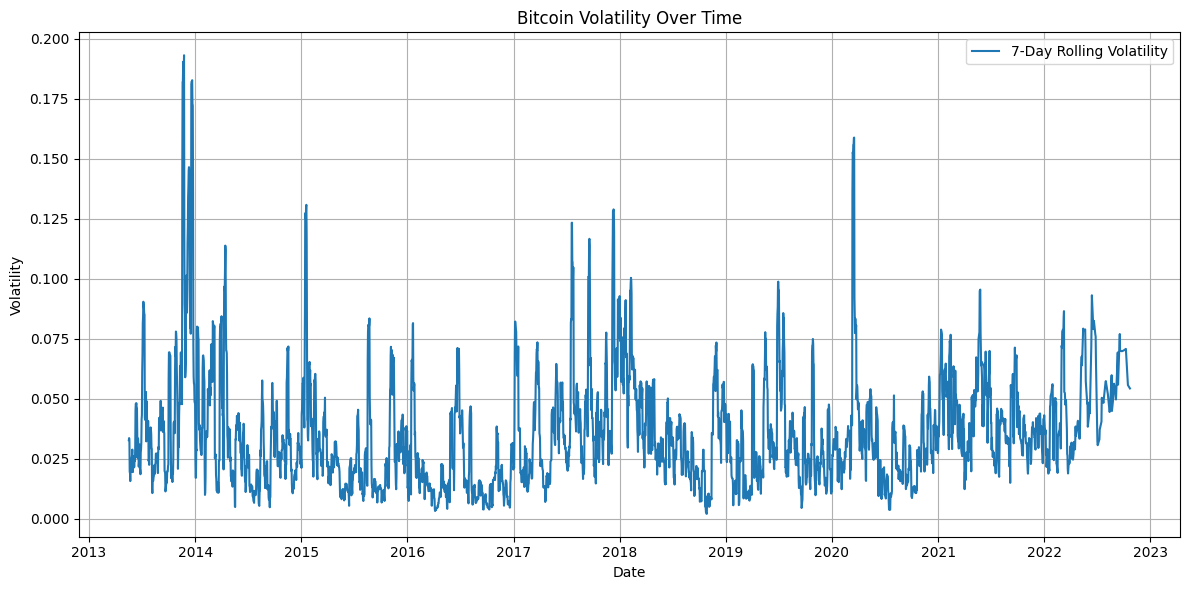

In [57]:
import matplotlib.pyplot as plt

btc_df = df[df['crypto_name'] == 'Bitcoin']

plt.figure(figsize=(12, 6))
plt.plot(btc_df['date'], btc_df['rolling_volatility_7d'], label='7-Day Rolling Volatility')
plt.title("Bitcoin Volatility Over Time")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Saving dataset.csv to dataset (2).csv


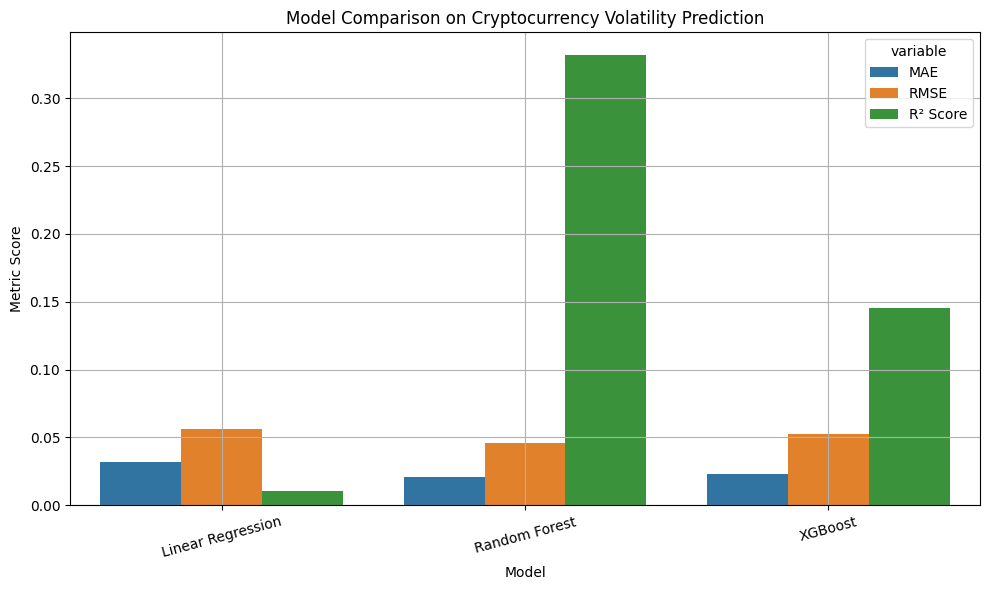

,Model,MAE,RMSE,R² Score
0,Linear Regression,0.031722,0.056172,0.010194
1,Random Forest,0.021073,0.046148,0.331935
2,XGBoost,0.022761,0.052188,0.145604


In [60]:
# 📌 STEP 1: Install and Import Libraries
!pip install xgboost --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 📌 STEP 2: Load Data (Upload CSV or Mount from Drive)
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(next(iter(uploaded)))
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by=['crypto_name', 'date'], inplace=True)

# STEP 3: Preprocessing
df.dropna(subset=['close', 'open', 'high', 'low', 'volume', 'marketCap'], inplace=True)
df['daily_return'] = df.groupby('crypto_name')['close'].pct_change()
df['rolling_volatility_7d'] = df.groupby('crypto_name')['daily_return'].rolling(window=7).std().reset_index(0, drop=True)
df['ma_7'] = df.groupby('crypto_name')['close'].rolling(window=7).mean().reset_index(0, drop=True)
df['ma_14'] = df.groupby('crypto_name')['close'].rolling(window=14).mean().reset_index(0, drop=True)
df['liquidity_ratio'] = df['volume'] / df['marketCap']
df.dropna(inplace=True)

#  STEP 4: Feature and Target Definition
features = ['open', 'high', 'low', 'close', 'volume', 'marketCap', 'daily_return', 'ma_7', 'ma_14', 'liquidity_ratio']
X = df[features]
y = df['rolling_volatility_7d']

# Step 5: Handle infinite values safely by copying the data first
X = X.copy()
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

# Align y accordingly
y = y.loc[X.index]


# Step 6: Scaling and Train-Test Split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


#  STEP 7: Define and Train Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R² Score': r2_score(y_test, y_pred)
    }

results_df = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Model"})

# 📌 STEP 8: Visualize Model Performance
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("Model Comparison on Cryptocurrency Volatility Prediction")
plt.ylabel("Metric Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.grid(True)
plt.show()

# Show result table
results_df


Shape of X for LSTM: (56082, 14, 10)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - loss: 0.0026 - val_loss: 7.0913e-04
Epoch 2/50
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - loss: 0.0018 - val_loss: 5.7287e-04
Epoch 3/50
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - loss: 0.0012 - val_loss: 7.3891e-04
Epoch 4/50
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - loss: 8.4110e-04 - val_loss: 0.0011
Epoch 5/50
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - loss: 7.1847e-04 - val_loss: 0.0011
Epoch 6/50
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 7.0361e-04 - val_loss: 8.0480e-04
Epoch 7/50
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 7.3076e-04 - val_loss: 7.6736e-04
439/439 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
LSTM Performance:
MAE: 0.0142, RMSE: 0.0277, R²: 0.6458


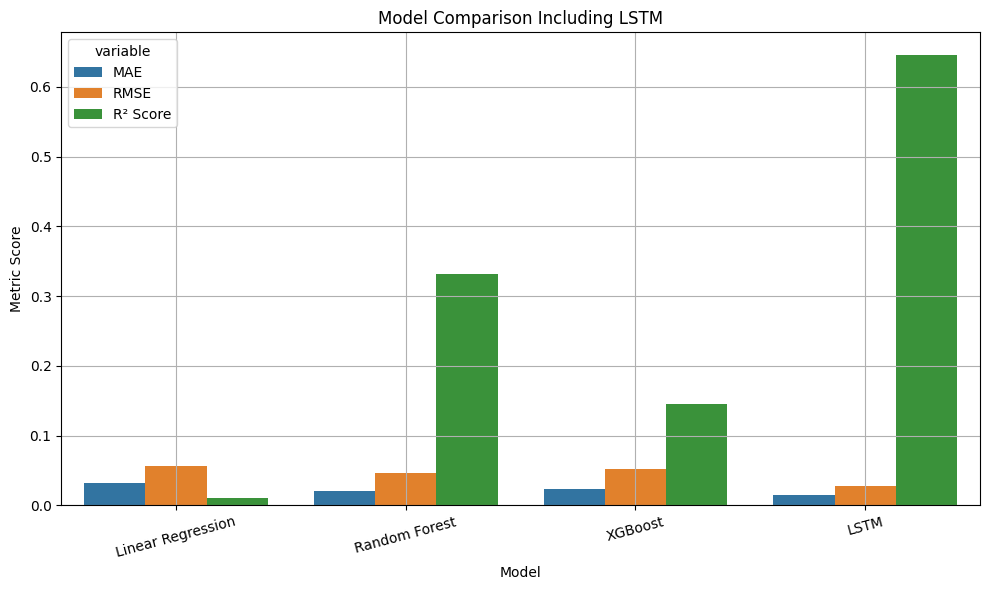

,Model,MAE,RMSE,R² Score
0,Linear Regression,0.031722,0.056172,0.010194
1,Random Forest,0.021073,0.046148,0.331935
2,XGBoost,0.022761,0.052188,0.145604
3,LSTM,0.014231,0.027701,0.645813


In [61]:
# 📌 STEP 9: Install TensorFlow and Import LSTM Tools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 📌 STEP 10: Sequence Preparation for LSTM
# Define time steps (look back)
LOOK_BACK = 14

# Reshape data into sequences
def create_sequences(X, y, look_back=LOOK_BACK):
    Xs, ys = [], []
    for i in range(look_back, len(X)):
        Xs.append(X[i - look_back:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y.values)

# Split into train/test
split_idx = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_test_seq = y_seq[:split_idx], y_seq[split_idx:]

print("Shape of X for LSTM:", X_train_seq.shape)

# 📌 STEP 11: Build LSTM Model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# 📌 STEP 12: Train the Model
early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# 📌 STEP 13: Evaluate LSTM Model
y_pred_lstm = lstm_model.predict(X_test_seq)

mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
r2_lstm = r2_score(y_test_seq, y_pred_lstm)

print(f"LSTM Performance:\nMAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}, R²: {r2_lstm:.4f}")

# 📌 STEP 14: Compare All Models Including LSTM
results_df.loc[len(results_df.index)] = ['LSTM', mae_lstm, rmse_lstm, r2_lstm]

# 📌 STEP 15: Visualization Update
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("Model Comparison Including LSTM")
plt.ylabel("Metric Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.grid(True)
plt.show()

# Show final table
results_df
